In [1]:
##Homework 5
import pandas as pd
import tqdm
import py2neo

In [2]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="homework5")

In [3]:
graph.delete_all()

In [ ]:
#establish a connection to Neo4j:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="homework5")
graph.delete_all()

In [4]:
#Read the "Twitch/FR_target.csv" file and create nodes in Neo4j:
nodes_df = pd.read_csv("Chap4/Homework_data/Twitch/FR_target.csv")

In [7]:
print(nodes_df)

             id  days  mature  views  partner  new_id
0     150417538   577    True    775    False    4867
1     125723704   861    True   2585    False    3692
2     155971814   523   False   1566    False    3816
3      35832890  2234   False   9713    False     416
4      46787750  1896    True  44529    False    4502
...         ...   ...     ...    ...      ...     ...
6546   29196284  2061   False   3822    False    6546
6547  124327806   880    True  30313    False    2392
6548  144229380   640    True   5022    False     391
6549  131423064   736   False   2658    False    2793
6550   45419243  1929    True   3743    False    1092

[6551 rows x 6 columns]


In [5]:
 nodes_df= nodes_df.drop_duplicates()

In [7]:
nodes_df['id'].value_counts()

89203888     2
150417538    1
32373692     1
86373910     1
2419161      1
            ..
131284152    1
92609127     1
54942772     1
103455447    1
45419243     1
Name: id, Length: 6549, dtype: int64

In [9]:
nodes_df.drop_duplicates(subset=['id', 'new_id'], keep='first',inplace=True)

In [11]:
import tqdm
import itertools

In [12]:
try:
    graph.run("CREATE CONSTRAINT ON (n:Streamer) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")
# Init the list that will contains dicts for each node
transaction_list = []
for row in tqdm.tqdm(nodes_df.iterrows()):
    id_ = row[1]["id"]
    views = row[1]["views"]
    days = row[1]["days"]
    mature = row[1]["mature"]
    new_id = row[1]["new_id"]
    partner = row[1]["partner"]
    transaction_list.append({"id_":id_,"views":views,"days":days,"mature":mature,"new_id":new_id,"partner":partner})
    if len(transaction_list) == 1000:
        # UNWIND = split the list given to it (here $json because json=transaction_list)
        # For each dict do the following query CREATE (n:Superhero) SET n = data
        transaction = "UNWIND $json as data CREATE (n:Streamer) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

# Some observation left (e.g 7700 node, will commit every 100. so 700 left)
graph.run(transaction, json=transaction_list)

pass

Constraint already exists


6549it [00:05, 1200.85it/s]


In [13]:
#Read the "Twitch/FR_edges.csv" file and create edges between nodes in Neo4j
edges_df = pd.read_csv("Chap4/Homework_data/Twitch/FR_edges.csv")
print(edges_df)

        from    to
0          0  6420
1          0  2941
2          0  3051
3          0  5511
4          0  1020
...      ...   ...
112661    77  6542
112662  6516  6527
112663  6520  6527
112664  6527  6542
112665  6527  6541

[112666 rows x 2 columns]


In [14]:
transaction_list = []
transaction = """UNWIND $json as data
MATCH (a:Streamer),(b:Streamer)
WHERE a.new_id = data.from AND b.new_id = data.to
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for edge in tqdm.tqdm(edges_df.groupby(["from"])):
    related_ids = edge[1]["to"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"from":sh1,"to":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)

  1%|          | 41/5882 [30:02<71:19:45, 43.96s/it] 


ConnectionBroken: Failed to read message

In [15]:
#1)Give the IDs of the top 10 streamers that have atleast one collaboration.
query = """MATCH (s:Streamer)
WHERE exists(s.id_)
RETURN s
ORDER BY s.views DESC
LIMIT 10"""
data = graph.run(query).to_data_frame()
list(data["s"])

[Node('Streamer', days=1479, id_=71852533, mature=False, new_id=3459, partner=True, views=108432615),
 Node('Streamer', days=1311, id_=84934385, mature=False, new_id=6420, partner=True, views=62713570),
 Node('Streamer', days=2613, id_=24147592, mature=False, new_id=5511, partner=True, views=44534929),
 Node('Streamer', days=2027, id_=41719107, mature=True, new_id=2161, partner=True, views=44374644),
 Node('Streamer', days=386, id_=174955366, mature=False, new_id=2799, partner=True, views=43059742),
 Node('Streamer', days=610, id_=147337432, mature=False, new_id=5968, partner=True, views=42801507),
 Node('Streamer', days=2075, id_=40063341, mature=False, new_id=1751, partner=True, views=38404078),
 Node('Streamer', days=660, id_=142506321, mature=False, new_id=5804, partner=True, views=37754841),
 Node('Streamer', days=2384, id_=29478753, mature=False, new_id=1552, partner=True, views=34295755),
 Node('Streamer', days=2460, id_=27528066, mature=False, new_id=5844, partner=True, views=2

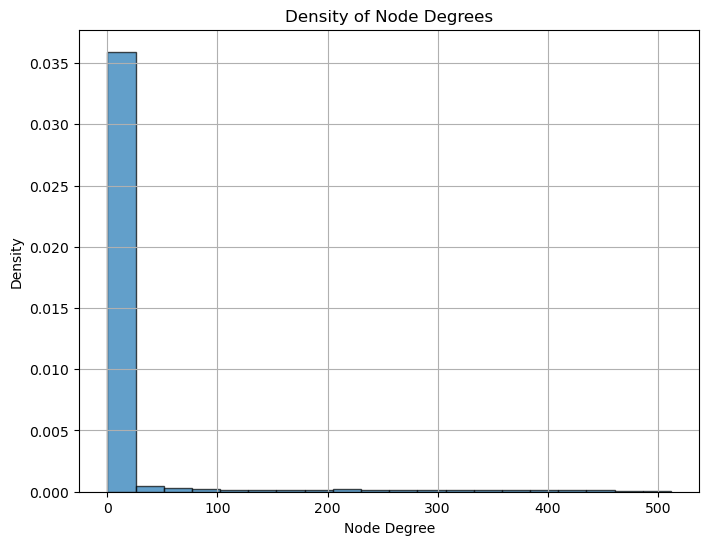

In [17]:
#2)Create a density of node degrees. Do you observe a power scale law ? What does it mean ?
import matplotlib.pyplot as plt
import numpy as np
from py2neo import Graph
query = """
MATCH (p)
WITH p, size((p)-[:RELATION]->()) AS degree
RETURN degree
"""

# Execute the query and retrieve the degrees
result = graph.run(query)
degrees = [record["degree"] for record in result]

# Create a density plot of node degrees
plt.figure(figsize=(8, 6))
plt.hist(degrees, density=True, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Density of Node Degrees')
plt.grid(True)
plt.show()

In [ ]:
## yes there is a power scale law

In [23]:
#3)How many streamers has the tag "mature" ?
query = """
MATCH (s:Streamer)
WHERE s.mature=true
with count(s) as nombre
RETURN nombre
"""
result = graph.run(query)

for record in result:
    number_stream_mature = record[0]
    print("Number of mature streamers:", number_stream_mature)

Number of mature streamers: 2414


In [24]:
#4)Is the collaboration correlated to the "mature" tag ?
query = """
MATCH (p:Streamer)-[r:RELATION]->()
where p.mature = TRUE
RETURN p.mature
"""
graph.run(query)

p.mature
true
true
true


In [28]:
#5)Do partners collaborate more than non partners ?
query = """
MATCH (s:Streamer)-[r:RELATION]->()
WHERE s.partner = True
with count(s) as nombre
return nombre
"""
result=graph.run(query)
for record in result:
    number_partners_who_collaborate = record[0]
    print("Number of partners who collaborate:", number_partners_who_collaborate)

Number of partners who collaborate: 29200


In [29]:
query = """
MATCH (s:Streamer)-[r:RELATION]->()
WHERE s.partner = false
with count(s) as nombre
return nombre
"""
result=graph.run(query)
for record in result:
    number_partners_who_nt_collaborate = record[0]
    print("Number of partners who doesnt collaborate:",number_partners_who_nt_collaborate )

Number of partners who doesnt collaborate: 86684


In [ ]:
#6)Sandbox exercise: think of a problematic and try to answer it.